In [22]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score
import matplotlib.pylab as plt
%matplotlib inline


# Customer Churn Prediction Using Machine Learning

This project aims to build and evaluate machine learning models to predict customer churn based on behavioral and demographic data. The goal is to identify the most influential features that contribute to customer retention or departure.

### Objectives:
- Build and compare models such as **Logistic Regression**, **Random Forest**, **XGboost** and **Balanced Random Forest**.
- Analyze model performance using metrics like **accuracy** and **confusion matrices**.
- Interpret model decisions using **SHAP (SHapley Additive Explanations)** for transparency.


### Dataset:
The dataset contains various customer attributes, including:
- Service usage patterns (Support Calls, Usage Frequency,Last interaction)
- Account information (Total Spend, Contract Length,Subscription Type,Contract Length and Payment Delay)
- Demographics (Age, Gender)

By understanding churn drivers, this project can help improve retention strategies and reduce customer loss.


# Exploratory Data Analysis(EDA)

In [3]:
df = pd.read_csv("/Users/tony/Documents/research_projects/uneeq_interns/Customer Churn/customer_churn_dataset-training-master.csv")

In [5]:
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [7]:
df.describe()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


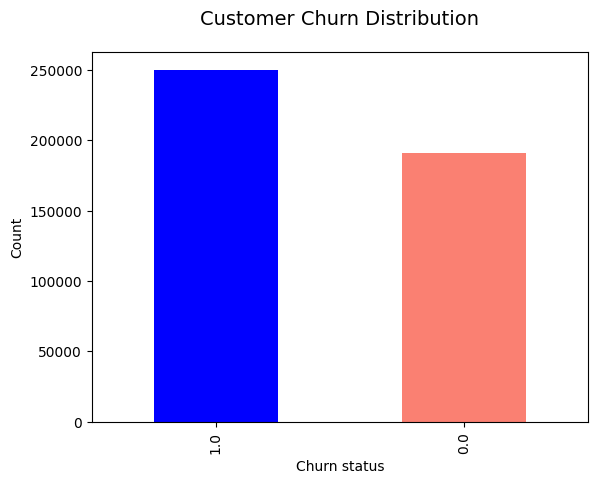

In [21]:
#churn rate

ax = df['Churn'].value_counts().plot(
    kind='bar',
    color = ['blue','salmon'])
ax.set_title("Customer Churn Distribution",fontsize = 14,pad=20)
ax.set_xlabel('Churn status')
ax.set_ylabel('Count')
plt.show()

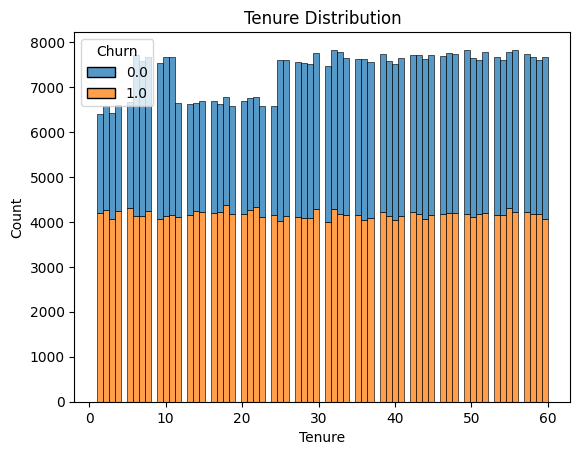

In [27]:

sns.histplot(data=df,x='Tenure',hue='Churn',multiple='stack')
plt.title("Tenure Distribution")
plt.show()

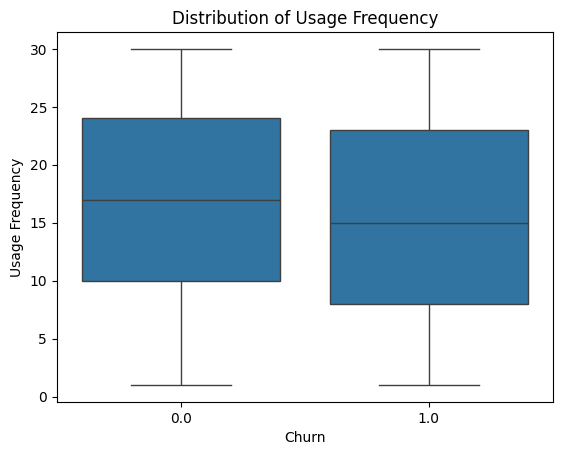

In [29]:
#usage frequency
sns.boxplot(x='Churn',y='Usage Frequency',data=df)
plt.title('Distribution of Usage Frequency')
plt.show()

Text(0, 0.5, 'Average Payment Delay')

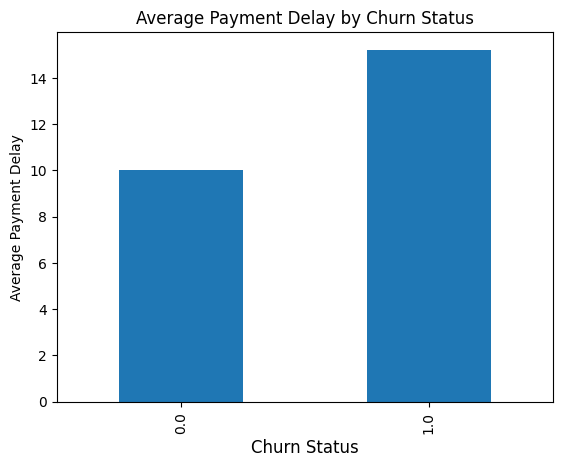

In [36]:
ax = df.groupby('Churn')['Payment Delay'].mean().plot(kind='bar')
ax.set_title("Average Payment Delay by Churn Status")
ax.set_xlabel('Churn Status', fontsize=12)
ax.set_ylabel('Average Payment Delay')

In [39]:
df = df.dropna()

In [43]:
dfa=df.select_dtypes(include=['number'])

<Axes: >

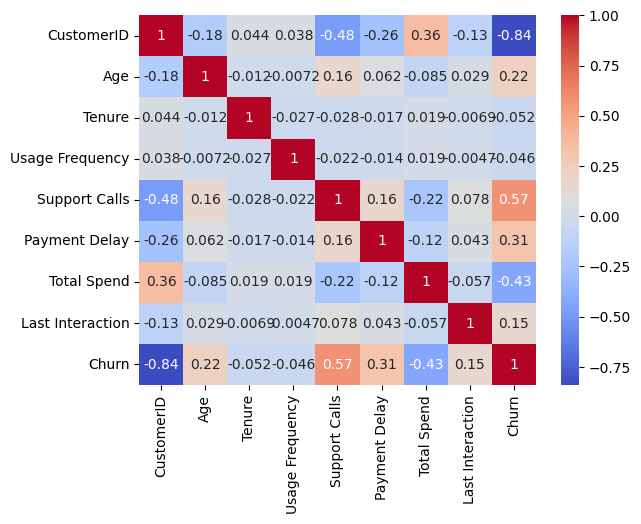

In [44]:
#Feature correlation matrix
sns.heatmap(dfa.corr(), annot=True, cmap='coolwarm')

In [47]:
dfa.corr()['Churn'].sort_values(ascending=False)

Churn               1.000000
Support Calls       0.574267
Payment Delay       0.312129
Age                 0.218394
Last Interaction    0.149616
Usage Frequency    -0.046101
Tenure             -0.051919
Total Spend        -0.429355
CustomerID         -0.839365
Name: Churn, dtype: float64

# Cleaning of data

In [4]:
df.isna().sum()

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [5]:
df = df.dropna()

In [6]:
df.isna().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [57]:
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [7]:
categorical_col = ['Gender','Subscription Type','Contract Length']

In [8]:
#label enconding train
label_encoders = {}
for col in categorical_col:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le



In [9]:
df.drop(columns="CustomerID")

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,0,39.0,14.0,5.0,18.0,2,0,932.00,17.0,1.0
1,65.0,0,49.0,1.0,10.0,8.0,0,1,557.00,6.0,1.0
2,55.0,0,14.0,4.0,6.0,18.0,0,2,185.00,3.0,1.0
3,58.0,1,38.0,21.0,7.0,7.0,2,1,396.00,29.0,1.0
4,23.0,1,32.0,20.0,5.0,8.0,0,1,617.00,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
440828,42.0,1,54.0,15.0,1.0,3.0,1,0,716.38,8.0,0.0
440829,25.0,0,8.0,13.0,1.0,20.0,1,0,745.38,2.0,0.0
440830,26.0,1,35.0,27.0,1.0,5.0,2,2,977.31,9.0,0.0
440831,28.0,1,55.0,14.0,2.0,0.0,2,2,602.55,2.0,0.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  int64  
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  int64  
 8   Contract Length    440832 non-null  int64  
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 43.7 MB


In [79]:
#correlation of the dataset to the churn
corr_matrix = df.corr(numeric_only=True)
corr_matrix['Churn'].sort_values(ascending=False)

Churn                1.000000
Support Calls        0.574267
Payment Delay        0.312129
Age                  0.218394
Last Interaction     0.149616
Contract Length     -0.000093
Subscription Type   -0.017181
Usage Frequency     -0.046101
Tenure              -0.051919
Gender              -0.175395
Total Spend         -0.429355
CustomerID          -0.839365
Name: Churn, dtype: float64

# Training

In [80]:
df.columns.tolist()

['CustomerID',
 'Age',
 'Gender',
 'Tenure',
 'Usage Frequency',
 'Support Calls',
 'Payment Delay',
 'Subscription Type',
 'Contract Length',
 'Total Spend',
 'Last Interaction',
 'Churn']

In [11]:
num_col = [
 'Age',
 'Tenure',
 'Usage Frequency',
 'Support Calls',
 'Payment Delay',
 'Total Spend',
 'Last Interaction'
 ]
target = ['Churn']

In [12]:
sc = StandardScaler()
df[num_col] = sc.fit_transform(df[num_col])
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,-0.753326,0,0.448760,-0.210511,0.454549,0.609620,2,0,1.247427,0.293052,1.0
1,3.0,2.059646,0,1.028278,-1.724562,2.083100,-0.601319,0,1,-0.309865,-0.986584,1.0
2,4.0,1.255940,0,-1.000036,-1.375166,0.780259,0.609620,0,2,-1.854698,-1.335575,1.0
3,5.0,1.497051,1,0.390808,0.604748,1.105969,-0.722413,2,1,-0.978462,1.689018,1.0
4,6.0,-1.315921,1,0.043097,0.488282,0.454549,-0.601319,0,1,-0.060698,0.642043,1.0


In [83]:
df.columns.tolist()

['CustomerID',
 'Age',
 'Gender',
 'Tenure',
 'Usage Frequency',
 'Support Calls',
 'Payment Delay',
 'Subscription Type',
 'Contract Length',
 'Total Spend',
 'Last Interaction',
 'Churn']

In [13]:
X = df.drop(columns=["Churn"],axis=1)
y = df["Churn"]

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [86]:

smote = SMOTE()
X_res, y_res = smote.fit_resample(X_train, y_train)

In [ ]:
#Logistic Re

In [33]:
#train the model
Lr = LogisticRegression(max_iter=1000)

Lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [34]:
preds = Lr.predict(X_test)

In [35]:
print(classification_report(y_test,preds,target_names=['Not Churn', 'Churn']))

              precision    recall  f1-score   support

   Not Churn       0.97      0.98      0.97     57396
       Churn       0.98      0.98      0.98     74854

    accuracy                           0.98    132250
   macro avg       0.98      0.98      0.98    132250
weighted avg       0.98      0.98      0.98    132250



In [95]:
roc_auc = roc_auc_score(y_test,preds)
print(f"ROC-AUC: {roc_auc:.2f}")  

ROC-AUC: 0.98


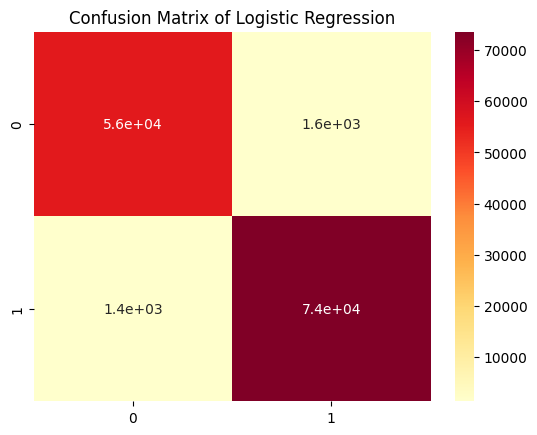

In [100]:
conf_matrix = confusion_matrix(preds,y_test)
sns.heatmap(conf_matrix,cmap='YlOrRd',annot=True)
plt.title("Confusion Matrix of Logistic Regression")
plt.show()

 99%|===================| 131523/132250 [01:23<00:00]        

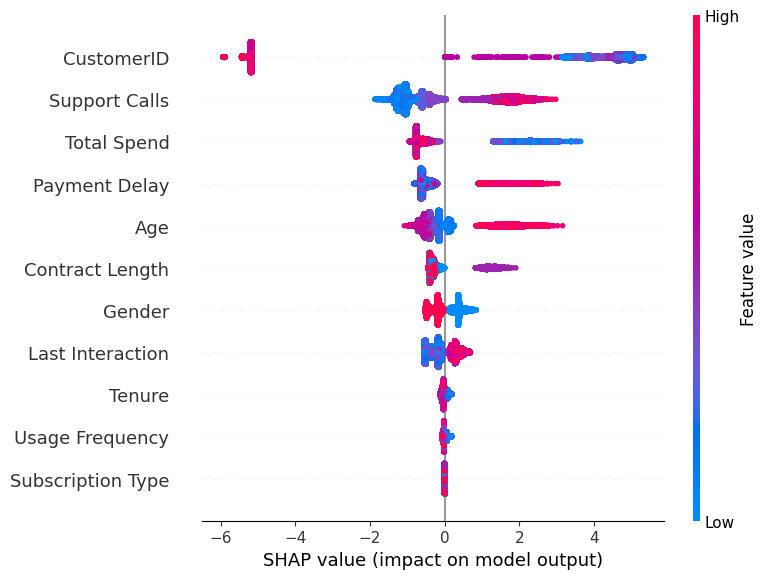

In [121]:
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns)


shap.plots.force(shap_values[0])  

# Random Forest

In [29]:
# Initialize and train
rf = RandomForestClassifier(random_state=42,
                            class_weight = "balanced",max_depth=10,n_estimators=100)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1] 



In [30]:
# metrics Evaluation
print(accuracy_score(y_pred,y_test))
print(classification_report(y_test, y_pred,target_names=['Not Churn', 'Churn']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.2f}")

0.9957731568998109
              precision    recall  f1-score   support

   Not Churn       1.00      0.99      1.00     57396
       Churn       0.99      1.00      1.00     74854

    accuracy                           1.00    132250
   macro avg       1.00      1.00      1.00    132250
weighted avg       1.00      1.00      1.00    132250

ROC-AUC: 1.00


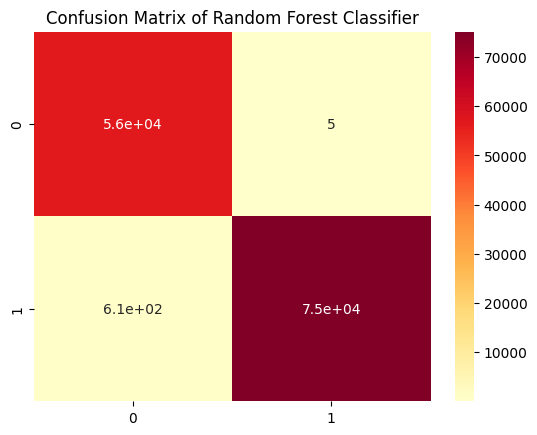

In [116]:
conf_matrix = confusion_matrix(y_pred,y_test)
sns.heatmap(conf_matrix,cmap='YlOrRd',annot=True)
plt.title("Confusion Matrix of Random Forest Classifier")
plt.show()

# XGBOOST 

In [26]:
model = xgb.XGBClassifier(
    objective="binary:logistic", 
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    max_depth=3,
    scale_pos_weight=2,
    eval_metric="aucpr",
    subsample = 0.8,
    reg_alpha = 1,
    
    
)

model.fit(X_train,y_train)

pre = model.predict(X_test)
y_probe = model.predict_proba(X_test)[:, 1]

In [27]:
print("Accuracy",accuracy_score(y_test,pre))
print(f"ROC {roc_auc_score(y_test,y_probe)}")
print(classification_report(y_test,pre,target_names=['Not Churn', 'Churn']))

Accuracy 0.9928695652173913
ROC 0.9999777950674266
              precision    recall  f1-score   support

   Not Churn       1.00      0.98      0.99     57396
       Churn       0.99      1.00      0.99     74854

    accuracy                           0.99    132250
   macro avg       0.99      0.99      0.99    132250
weighted avg       0.99      0.99      0.99    132250



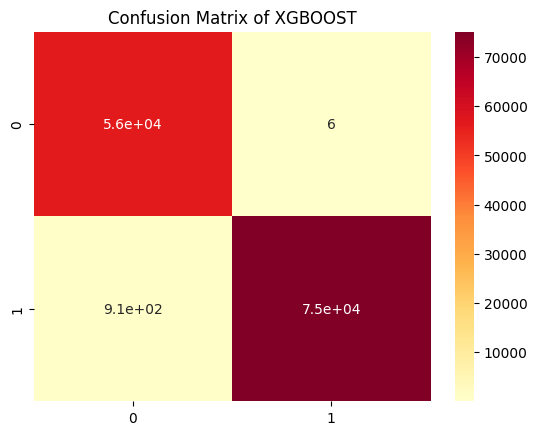

In [117]:
conf_matrix = confusion_matrix(pre,y_test)
sns.heatmap(conf_matrix,cmap='YlOrRd',annot=True)
plt.title("Confusion Matrix of XGBOOST")
plt.show()

# Balanced Random Forest

In [15]:
brf = BalancedRandomForestClassifier(random_state=42)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=42)

In [16]:
brf.fit(X_train,y_train)

pree = brf.predict(X_test)
y_probee = brf.predict_proba(X_test)[:, 1]

In [23]:
print("Accuracy",accuracy_score(y_test,pree))
print(f"ROC {roc_auc_score(y_test,y_probee)}")


Accuracy 0.9995841209829868
ROC 0.9999990347553668


In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pree, target_names=['Not Churn', 'Churn']))

              precision    recall  f1-score   support

   Not Churn       1.00      1.00      1.00     57396
       Churn       1.00      1.00      1.00     74854

    accuracy                           1.00    132250
   macro avg       1.00      1.00      1.00    132250
weighted avg       1.00      1.00      1.00    132250



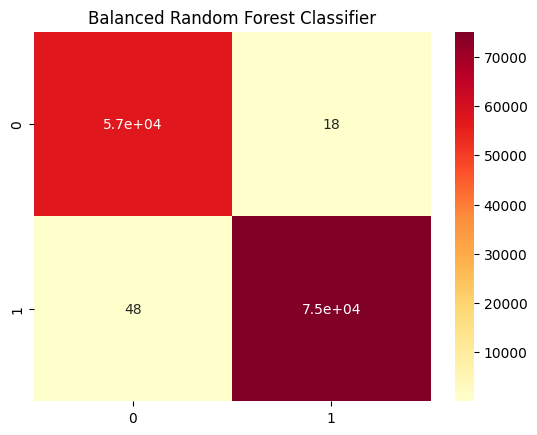

In [115]:
conf_matrix = confusion_matrix(pree,y_test)
sns.heatmap(conf_matrix,cmap='YlOrRd',annot=True)
plt.title("Balanced Random Forest Classifier")
plt.show()


**Best Model**: Balanced Random Forest  
- **Why**: Highest recall (100%) as catches most churners  
- **Tradeoff**: it is slower than others  

**Action**: It is better to use Balanced RF if preventing churn is the priority in this task  